# **Deep Q-Network Route Finder**

Here in this jupyter notebook, we will have some fun with using reinforcement learning to find safe routes across the ice.
This notebook draws a lot of inspiration from Open AI's [FrozenLake](https://gym.openai.com/envs/FrozenLake8x8-v0/) gym environment.
Really, how nice of them to have a well crafted toy problem already thought out for us!

Specifically and technically, we will train a Deep Q-Network in Keras/Tensorflow to help us decide safe routes across slippery ice!
Later, we will move on to applying this safe navigation tool to our crevasse avoidance problem.

References:
- Open AI [gym](https://github.com/openai/gym) 
- [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
- [Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)
- [Frozen Lake github gist using Keras](https://gist.github.com/ceshine/eeb97564c21a77b8c315179f82b3fc08)
- [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)
- [Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG)](https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287)

In [1]:
# Import all the necessary libraries
import os
import random
import sys
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  #set to see only the 3rd gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.simplefilter(action = "ignore", category = FutureWarning)

import affine
import math
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import rasterio
import scipy.spatial
%matplotlib inline

import gym
from gym.utils import seeding
import quilt

import keras
import tensorflow as tf
import rl
#import hyperopt

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input, Concatenate
from keras.layers.core import Activation, Flatten, Dropout, Reshape
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Scipy        :', scipy.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Keras        : 2.1.5
Scipy        : 1.0.1
Tensorflow   : 1.6.0


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

## Design Keras Model to fit into Q-Network

In [3]:
def keras_convnet(input_shape=(128,128,1)):
    """
    The Keras Convolutional Network that parses the incoming pixel data.
    Based on Mnih et al. 2015's "Playing Atari with Deep Reinforcement Learning" paper
    Consists of 2 Convolutional Layers, and 1 Dense Layer, plus 1 Linear output Layer
    
    Inputs:
    input_shape -- shape of the input tensor, (height, width, channels)
    
    Outputs:
    model -- keras.models.Model instance
    
    """
    inp = Input(shape=input_shape)
    assert(inp.shape.ndims == 4)  #needs to be shape like (?,4,4,1) for 4x4 grid, (?,8,8,1) for 8x8 grid
        
    X = Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), padding='valid', activation='relu')(inp)
    X = Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='valid', activation='relu')(X)
    X = Flatten()(X)
    X = Dense(units=256, activation='relu')(X)
    X = Dense(units=4, activation='linear')(X)
    
    model = Model(inputs=inp, outputs=X) 
    
    return model

# CrevasseCrosser gym environment

## Implement our own CrevasseCrosser class based on OpenAI FrozenLake gym

Borrows some elements from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

**Note**: There are a lot of Python classes wrapping functions to implement this CrevasseCrosserEnv (read: can be hard to follow if you're not familiar with the OpenAI gym). If you are looking for the previous pure numpy implementation that more clearly illustrates the mechanics, you can check out an older version at this [git commit](https://github.com/weiji14/nz_space_challenge/blob/11c293a1c30029b4717c0e40111c56f047dea3c0/route_finder.ipynb).

### Load map grid environment (the crevasse laden terrain our virtual player will be crossing) from quilt

In [4]:
quilt.install(package='weiji14/nz_space_challenge', hash='2caa196b', force=True)

100%|██████████| 490M/490M [00:00<00:00, 69.1GB/s]

(3616, 7200, 1)


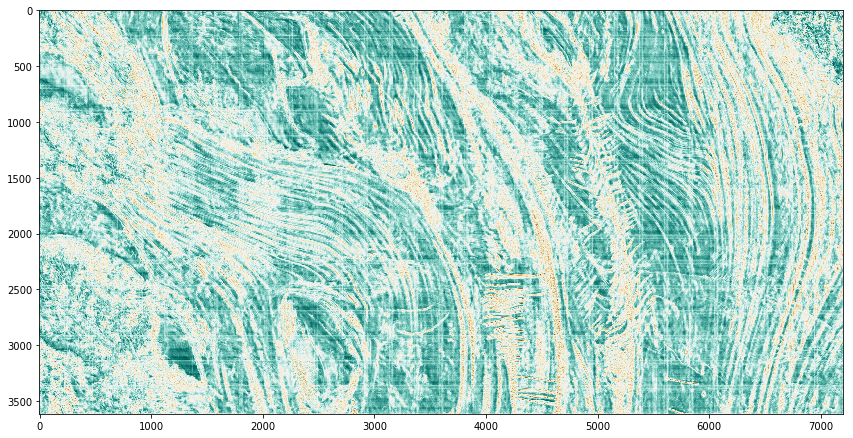

In [5]:
from quilt.data.weiji14 import nz_space_challenge
with rasterio.open(fp=nz_space_challenge.intertrain.crevasse_map()) as raster_source:
    map_env = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
    map_env = np.rollaxis(a=map_env, axis=0, start=3)   #change to shape (height, width, 1)
    print(map_env.shape)
    transform = raster_source.transform

fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(14.4,9.6))
axarr[0, 0].imshow(-map_env[:,:,0], cmap='BrBG')

### **CrevasseCrosser** custom OpenAI gym environment class!

In [6]:
#https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai/47132897#47132897
class CrevasseCrosserEnv(gym.Env):
    """
    An OpenAI gym compatible custom environment inspired from the FrozenLake env!
    
    The map should be a 2D numpy array, with values on each xy position indicating the
    penalty for stepping on to that position. The centre pixels, specifically a 2x2 square,
    will be where our player is assumed to be located. Moving around the map environment 
    is done using a scrolling method, similar to classic RPG games! Not sure if I explained
    this intuitively enough :P
    
    Anyways, E.g. if values range from 0 to 1
    Values close to '1' would indicate a hole or 'H' in the FrozenLake env
    Values close to '0' would indicate the goal or 'G' in the FrozenLake env
    Values in between '0.25-0.75' would be the free spot or 'F' in the FrozenLake env, note that we penalize steps!
    There is not really a starting point 'S', we always assume the player is in the centre
    """
    
    def __init__(self, map_env:np.ndarray=None, observation_window:tuple=(128,128,1),
                 transform:affine.Affine=None, start_xy:tuple=None, end_xy:tuple=None):
        
        self.map_env = map_env
        assert(isinstance(self.map_env, np.ndarray))  #check that we are passing in a numpy array
        assert(map_env.ndim==3)  #check that we have a map_env of shape (height, width, channels)
                
        self.observation_window = observation_window
        assert(len(self.observation_window) == 3)  #check that we have a observation window of shape (height, width, channels)
        assert(self.observation_window[0]%2 == 0)  #check that our observation window height is an even number
        assert(self.observation_window[1]%2 == 0)  #check that our observation window width is an even number
        
        self.map_env_shape = self.map_env.shape    #create an alias to the map_env shape
        assert(self.map_env_shape[-1] == self.observation_window[-1])  #check that the no. of channels in our map_env matches the no. of channels in our observation_window
        assert(self.map_env_shape[-1] == 1)  #check that we only have a one band/channel input, TODO remove when moving to more bands!
        
        self.info = None      #dictionary to store geographic coordinates of our player
        self.gameover = None  #boolean setting to store whether game round is over
        self.centrepoint = {'pixel_midy':None, 'pixel_midx': None}  #initialize this observation centrepoint variable

        ## number of Actions (discrete)
        ## Define what our agent can do, i.e. move left, down, right, up
        self.nA = 4
        self.action_space = gym.spaces.Discrete(self.nA)
        
        self.transform = transform
        self.start_xy = start_xy
        self.end_xy = end_xy
        
        self.current_observation = self.reset()    #reset our current observation to a random or designated initial state
        
        if self.start_xy is not None or self.end_xy is not None:
            assert(self.transform is not None)     #check that affine transform is available, so coordinates can be converted!!
            if self.start_xy is not None:
                assert(len(self.start_xy) == 2)    #check that we are passing in 2 numbers (x_coordinate, y_coordinate)
            if self.end_xy is not None:
                assert(len(self.end_xy) == 2)      #check that we are passing in 2 numbers (x_coordinate, y_coordinate)
                self.geodist_to_goal = scipy.spatial.distance.euclidean(u=(self.centrepoint['geo_midx'], self.centrepoint['geo_midy']),
                                                                        v=self.end_xy)
        
    def reset(self):
        """
        Function to reset the entire environment
        
        if self.start_xy is None:
            Set our player at some random place on the map
        elif self.start_xy is (x_coord, y_coord):
            Set our player at the designated place
        """
        self.info = None
        self.gameover = False
        self.lastaction = None
        
        ## Get random x and y positions (image coordinates) from the map_env that are not too close to the border
        if self.start_xy is None:
            pixel_midy = np.random.randint(low=0+2*self.observation_window[0],
                                           high=self.map_env.shape[0]-2*self.observation_window[0])
            pixel_midx = np.random.randint(low=0+2*self.observation_window[1],
                                           high=self.map_env.shape[1]-2*self.observation_window[1])
        else:
            pixel_midy, pixel_midx = rasterio.transform.rowcol(transform=self.transform,
                                                               xs=self.start_xy[0], ys=self.start_xy[1],
                                                               op=math.ceil)  #math.ceil rounds to bottom right in image coords
            assert(0 <= pixel_midy < self.map_env.shape[0])  #check (roughly) that our y is within the map environment
            assert(0 <= pixel_midx < self.map_env.shape[1])  #check (roughly) that our x is within the map environment
        
        self.current_observation, self.centrepoint = self.set_observation(pixel_midy=pixel_midy, pixel_midx=pixel_midx)
        
        return self.current_observation  #return initial observation
    
    
    def set_observation(self, pixel_midy:int, pixel_midx:int):
        """
        Crop a 2D slice out of our map environment given an input midpoint
        Note that the midpoint should reference the bottom right corner
        of the pixel, so that the array slicing method will be correct!!
        """
        pixel_y0 = pixel_midy - int(self.observation_window[0]/2)
        pixel_y1 = pixel_midy + int(self.observation_window[0]/2)
        pixel_x0 = pixel_midx - int(self.observation_window[1]/2)
        pixel_x1 = pixel_midx + int(self.observation_window[1]/2)
        
        observation = self.map_env[pixel_y0:pixel_y1,
                                   pixel_x0:pixel_x1, :]
        try:
            assert(observation.shape == self.observation_window)  #check that obsevation is within map environment!
        except:
            print(f"{observation.shape} is less than {self.observation_window}")
            raise
        
        centrepoint = {'pixel_midy': pixel_midy, 'pixel_midx': pixel_midx}
        
        if self.transform is not None:
            geo_midx, geo_midy = rasterio.transform.xy(transform=self.transform,
                                                       cols=pixel_midx,
                                                       rows=pixel_midy,
                                                       offset='lr')  #convert image coordinates to geographic coordinates
            centrepoint.update({'geo_midy': geo_midy, 'geo_midx': geo_midx})
        
        return observation, centrepoint
    
    
    def step(self, action):
        """
        Moves our player around the environment by applying an action
        
        Returns:
        (observation, reward, done, info)
        """
        if self.gameover == True:
            return (self.current_observation, 0, True, {})
        
        ## Get new OBSERVATION after making an action
        new_pixel_midy = self.centrepoint['pixel_midy']
        new_pixel_midx = self.centrepoint['pixel_midx']
        
        try:
            assert(isinstance(action, int))
        except AssertionError:
            action = np.argmax(a=action)  #used for actor-critic environment?
        
        if action == 0: #Left <-
            if new_pixel_midx - self.observation_window[1]/2 - 1 > 0:
                new_pixel_midx -= 1
        elif action == 1: #Down v
            if new_pixel_midy + self.observation_window[0]/2 + 1 > self.map_env_shape[0]:
                new_pixel_midy += 1
        elif action == 2: #Right ->
            if new_pixel_midx + self.observation_window[1]/2 + 1 > self.map_env_shape[1]:
                new_pixel_midx += 1
        elif action == 3: # Up ^
            if new_pixel_midy - self.observation_window[0]/2 - 1 < 0:
                new_pixel_midy -= 1
        
        self.current_observation, self.centrepoint = self.set_observation(pixel_midy=new_pixel_midy,
                                                                          pixel_midx=new_pixel_midx)
        
        ## Get REWARD from centre 2x2 grid square
        midsquare_vals = self.map_env[self.centrepoint['pixel_midy']-1:self.centrepoint['pixel_midy']+1,
                                      self.centrepoint['pixel_midx']-1:self.centrepoint['pixel_midx']+1, :]
        midsquare_max = np.max(midsquare_vals)  #get maximum of the midsquare pixels
        reward = -midsquare_max  #reward is negative integer as it is a penalty!
        
        ## Get DONE (or not) status
        _, bin_edges = np.histogram(a=self.current_observation, bins=10)  #split current_observation into ten deciles
        '''     0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 = bin_edges
                        |          |    |            
             <-good goal|       median  | bad hole->               '''
        if midsquare_max >= bin_edges[6]:  #i.e. if we're in a crevasse!
                done = self.gameover = True
        else:
            if self.end_xy is None:  #when we don't have a set endpoint
                if midsquare_max > bin_edges[2] and midsquare_max < bin_edges[6]: #if in a free spot
                    done = False
                elif midsquare_max <= bin_edges[2]:  #i.e. we've reached the goal!
                    difficulty = np.sum(self.current_observation)  #sum of all the pixels give indication of difficulty of map
                    bonus = (difficulty/np.product(a=self.observation_window)) * 50  #modulate the bonus with size of observation_window
                    reward += bonus  #give a bonus of a few points related to difficulty of the map
                    done = self.gameover = True

            elif self.end_xy is not None:  #when we have set an endpoint
                geo_resolution = self.transform.a  #equal to self.transform[0], assuming x and y resolution are the same
                new_geodist_to_goal = scipy.spatial.distance.euclidean(u=(self.centrepoint['geo_midx'], self.centrepoint['geo_midy']),
                                                                       v=self.end_xy)
                if new_geodist_to_goal < geo_resolution:  #when we are within the spatial resolution of the endpoint
                    bonus = 10   #arbitrary bonus for reaching the goal
                    reward += bonus
                    done = self.gameover = True
                elif new_geodist_to_goal >= geo_resolution:
                    delta_dist = new_geodist_to_goal - self.geodist_to_goal  #new distance to goal minus old distance to goal
                    #raise ValueError(new_geodist_to_goal, delta_dist)
                    bonus = -delta_dist/geo_resolution  #negative delta_dist normalized by spatial resolution
                    reward += bonus
                    done = False           
                self.geodist_to_goal = new_geodist_to_goal
            
    
        ## Get INFO about coordinates of midpoint
        if self.transform is not None:
            self.info = {'geo_x': self.centrepoint['geo_midx'], 'geo_y': self.centrepoint['geo_midy']}
            if self.end_xy is not None:
                self.info.update({'geodist_to_goal': self.geodist_to_goal})
        else:            
            self.info = {'geo_x': None, 'geo_y': None}

        self.lastaction = action
        return (self.current_observation, reward, done, self.info)
    
    
    def render(self, mode='human'):
        """
        Matplotlib function to plot the current observation window
        with the player position in the middle as a 2x2 grid box
        """
        fig, axarr = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(5,5))
        #axarr[0, 0].imshow(X=self.player_position[:,:,0], cmap='winter')
        axarr[0, 0].imshow(X=-self.current_observation[:,:,0], cmap='BrBG')
        upper_left_y = self.observation_window[0]/2 - 1 - 0.5 
        upper_left_x = self.observation_window[1]/2 - 1 - 0.5
        axarr[0, 0].add_patch(matplotlib.patches.Rectangle(xy=(upper_left_x,upper_left_y),
                                                           width=2,
                                                           height=2,
                                                           fill=False,
                                                           edgecolor='red',
                                                           linewidth=2))
        
        if self.lastaction is not None:
            actionTaken = ["Left","Down","Right","Up"][self.lastaction]
            print(f"  ({actionTaken}, {self.info})")
        else:
            print("")
        return plt.show()
    
    
    def seed(self, seed=None):
        """
        Just a simple function to set the seed of our gym environment
        """
        self.np_random, seed = gym.utils.seeding.np_random(seed=seed)
        return [seed]

### Crevasse Environment Processor

In [7]:
# Refer to https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py
from rl.core import Processor

class CrevasseEnvProcessor(Processor):
    """
    This processor takes the env observation (index position of the player)
    and returns a stacked 2 channel 2D array of shape (?, height, width, 2)
    containing the player position (channel 1) and the map grid (channel 2)
    """        
    def process_state_batch(self, batch):
        #print("b", batch.shape, batch.ndim, batch)
        assert(batch.ndim > 4)
        processed_batch = np.concatenate(batch, axis=0)
        #print("pb", processed_batch.shape)
        assert(processed_batch.ndim == 4)
        #assert(processed_batch.shape == (1,8,8,2))
        return processed_batch

### Callback to plot reward and number steps taken per episode

In [8]:
# See also https://github.com/keras-rl/keras-rl/blob/master/rl/callbacks.py
from keras.callbacks import Callback

class plot_reward_and_steps(Callback):
    def __init__(self, plot_interval:int=200, figsize=(15,3)):
        super().__init__()
        self.figsize = figsize                   #size of each subplot
        self.plot_interval = int(plot_interval)  #the number of episodes that elapsed when we want to plot a graph, default=200
        self.episode_count = 0                   #counter that keeps track of no. of episodes that have passed
        self.logs_list = []                      #Python list to store all our log information!
        
    def on_episode_end(self, episode, logs={}):
        self.logs_list.append(logs.copy())      #append log info into logs_list
        self.episode_count += 1                 #add 1 to episode_count
        
        if self.episode_count % self.plot_interval == 0:  #when our episode_count divided by the plot_interval has remainder of 0
           
            stepsList = [log['nb_episode_steps'] for log in self.logs_list]
            rewardList = [log['episode_reward'] for log in self.logs_list]
            
            fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=self.figsize)
            axarr[0, 0].plot(rewardList[-self.plot_interval:], color='blue')  #plot to see e.g. last 200 rewardTallies
            axarr[0, 0].set_title('Reward Tally over each episode')
            #axarr[0, 0].set_ylim([-7.5,7.5])
            axarr[0, 1].plot(stepsList[-self.plot_interval:], color='orange')  #plot to see e.g. last 200 number of steps taken
            axarr[0, 1].set_title('No. of steps taken over each episode')
            #axarr[0, 1].set_ylim([0,100])
            plt.show();
            
            self.logs = []    #clear our logs_list

# Setup the training environment

In [9]:
observation_window = (128,128,1)
#env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform)
env = CrevasseCrosserEnv(map_env=map_env, observation_window=observation_window, transform=transform, start_xy=(2800,-904550), end_xy=(12093,-881519))
env.seed(seed=seed)

[42]

  (Left, {'geo_x': 2862.5, 'geo_y': -904737.5, 'geodist_to_goal': 24986.01353757738})


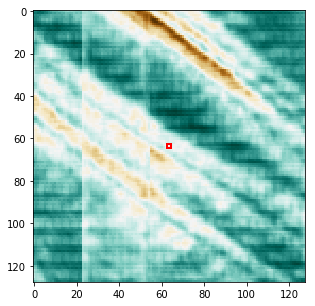

observation -0.6548245365610346 False {'geo_x': 2862.5, 'geo_y': -904737.5, 'geodist_to_goal': 24986.01353757738}


In [10]:
#Unit tests
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
env.render()
print('observation', reward, done, info)

### Build and compile the Deep Q-Network(DQN) model

Refer to implementation at https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [11]:
# Some hyperparameters that can be tweaked!
params = {'episodes': 1000,         #rough number of episodes we want to train the model on
          'learning_rate': 0.001,   #Adam optimizer learning rate
          'epsilon_max': 1.0,       #Maximum epsilon at start of training
          'epsilon_min': 0.1,       #Minimum epsilon at end of training
          'memory_size': 1000       #The number of historical steps and observations to keep
         }
# Miscellaneous fixed parameters
fixed_params = {'observation_input_shape': observation_window,   #e.g. (128,128,1)
                'plot_interval': 100,   #number of steps taken before plotting reward/steps per episode info
                'nb_actions': 4        #number of actions we can take i.e. left, down, right, up
                }
nb_max_episode_steps = fixed_params['nb_max_episode_steps'] = 100  #maximum number of steps per episode before stopping the player
nb_steps = fixed_params['nb_steps'] = params['episodes'] * (nb_max_episode_steps/2)   #number of steps corresponding to roughly 1000 episodes
log_interval = fixed_params['log_interval'] = 200 * (nb_max_episode_steps/2)   #print log data for roughly every 200 episodes
plot_info = fixed_params['plot_info'] = plot_reward_and_steps(plot_interval=fixed_params['plot_interval'], figsize=(15, 3))  #no. of steps b4 plotting reward/steps per episode

params.update(fixed_params)

In [12]:
def route_finder_model(params:dict=None):
    """
    Relatively self contained function that initializes a Deep Q-Network model given certain parameters
    """
    assert(isinstance(params, dict))  #check that we have passed in a dictionary of parameters!
   
    # Arguments to pass into dqn_model.fit
    episodes = params['episodes']  #rough number of episodes we want to train the model on
    nb_max_episode_steps = params['nb_max_episode_steps']  #maximum number of steps per episode before stopping the player
    # Assuming an episode finishes in a quarter of the max_episode_steps
    nb_steps= params['nb_steps']
    log_interval = episodes/2 * (nb_max_episode_steps/2)   #print log data for roughly every 200 episodes
    plot_info = params['plot_info']
    
    # Keras Convnet model parameters
    optimizer = keras.optimizers.Adam(lr=params['learning_rate'])
    model = keras_convnet(input_shape=params['input_shape'])
    plot_info = plot_reward_and_steps(plot_interval=100, figsize=(15, 3))
    ## Deep Q-Network model parameters
    policy = LinearAnnealedPolicy(inner_policy=EpsGreedyQPolicy(),
                                  attr='eps',
                                  value_max=params['epsilon_max'],
                                  value_min=params['epsilon_min'],
                                  value_test=0.05,
                                  nb_steps=nb_steps)
    processor = CrevasseEnvProcessor()
    nb_actions = params['nb_actions']
    memory = SequentialMemory(limit=params['memory_size'], window_length=1)
    
    ## Compile the DQN Agent
    dqn_model = DQNAgent(model=model, policy=policy,
                         memory=memory, processor=processor,
                         nb_actions=nb_actions, nb_steps_warmup=50,
                         batch_size=32, target_model_update=100,
                         enable_double_dqn=True, enable_dueling_network=True)
    dqn_model.compile(optimizer=optimizer)
    #dqn_model.model.summary()
    
    ## Uncomment this block for Hyperopt!
    ### **Train the Deep Q-Network iteratively here**
    #history = dqn_model.fit(env=env, nb_steps=nb_steps, log_interval=log_interval, nb_max_episode_steps=nb_max_episode_steps)
    #loss = -np.mean(history.history['episode_reward'])   #use the mean episode_reward as our loss
    #print(f"Mean episode_reward: {-loss}")
    ### Evaluation metrics
    #evaluation_info = dqn_model.test(env=env, nb_episodes=1, nb_max_episode_steps=14, visualize=False)   #evaluate on 14 steps
    #mean_reward = np.mean(evaluation_info.history['episode_reward'])   #the higher or more positive the reward value, the better
    #
    #return {'loss': loss, 'mean_reward': mean_reward, 'status': STATUS_OK} #, 'dqn_model': dqn_model, 'model': model}
    
    return dqn_model

In [14]:
dqn_model = route_finder_model(params=params)
dqn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
_________________________________________________________________
lambda_1 (Lambda)            (None, 4)                 0         
Total para

### **Train the Deep Q-Network iteratively here**

Training for ~1000 episodes with max 100 steps, logging every 10000.0 steps
Training for 50000.0 steps ...
Interval 1.0 (0 steps performed)
10000/10000 [==============================] - 268s 27ms/step - reward: -0.1826
197 episodes - episode_reward: -9.168 [-38.591, 16.331] - loss: 0.226 - mean_q: 3.529 - mean_eps: 0.910

Interval 2.0 (10000 steps performed)
 2058/10000 [=====>........................] - ETA: 3:27 - reward: -0.1443

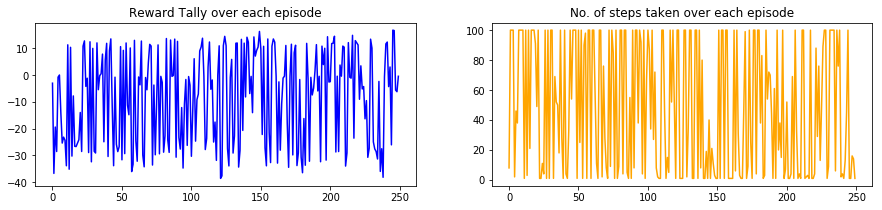

10000/10000 [==============================] - 267s 27ms/step - reward: -0.1352
233 episodes - episode_reward: -5.814 [-38.186, 16.814] - loss: 0.184 - mean_q: 6.691 - mean_eps: 0.730

Interval 3.0 (20000 steps performed)
 3481/10000 [=========>....................] - ETA: 2:51 - reward: -0.1702

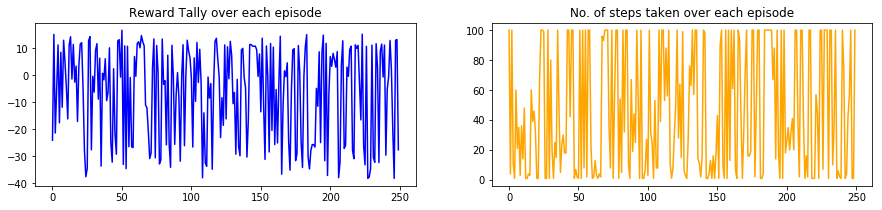

10000/10000 [==============================] - 282s 28ms/step - reward: -0.1510
205 episodes - episode_reward: -7.315 [-39.299, 16.073] - loss: 0.175 - mean_q: 6.351 - mean_eps: 0.550

Interval 4.0 (30000 steps performed)
 5188/10000 [==============>...............] - ETA: 2:19 - reward: -0.1081

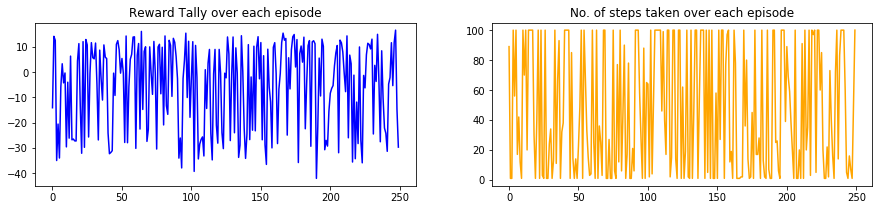

10000/10000 [==============================] - 302s 30ms/step - reward: -0.0342
279 episodes - episode_reward: -1.252 [-42.062, 16.879] - loss: 0.153 - mean_q: 4.753 - mean_eps: 0.370

Interval 5.0 (40000 steps performed)
 2708/10000 [=======>......................] - ETA: 3:36 - reward: -0.0146

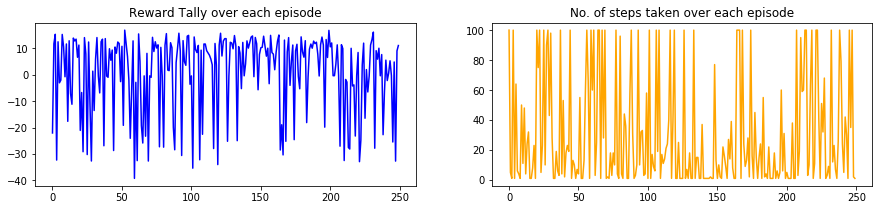

10000/10000 [==============================] - 309s 31ms/step - reward: -0.0302
done, took 1427.920 seconds


In [15]:
print(f"Training for ~{params['episodes']} episodes with max {nb_max_episode_steps} steps, logging every {log_interval} steps")
dqn_model.fit(env=env, nb_steps=nb_steps, log_interval=log_interval, nb_max_episode_steps=nb_max_episode_steps, callbacks=[plot_info])

In [16]:
#raise ValueError('temp')

TODO: Make an Asynchronous Advantage Actor-Critic A3C implementation in Keras!

References:

- [Reinforcement Learning w/ Keras + OpenAI: Actor-Critic Models](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69)
- [Let’s make an A3C: Implementation](https://jaromiru.com/2017/03/26/lets-make-an-a3c-implementation/)
- [Deep Reinforcement Learning Flappy Bird](https://shalabhsingh.github.io/Deep-RL-Flappy-Bird/)
- [Asynchronous Advantage Actor-Critic (A3C) (Tensorflow)](https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/6-3-A3C/)
- [Intuitive RL: Intro to Advantage-Actor-Critic (A2C)](https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752)

### Save the DQN model!

In [17]:
dqn_model.save_weights(filepath='model/weights/dqn-model-weights.hdf5', overwrite=True)

### See how our player does

In [18]:
dqn_model.load_weights(filepath='model/weights/dqn-model-weights.hdf5')  #reload the saved dqn model weights

Testing for 1 episodes ...
  (Down)


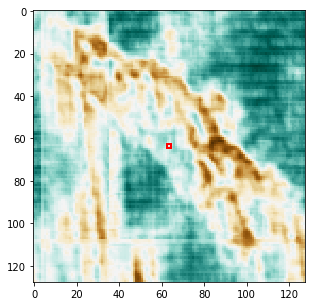

  (Down)


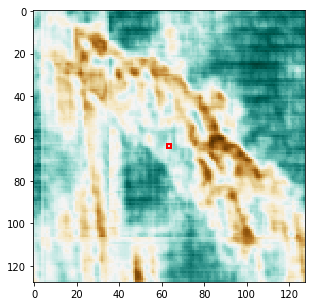

  (Down)


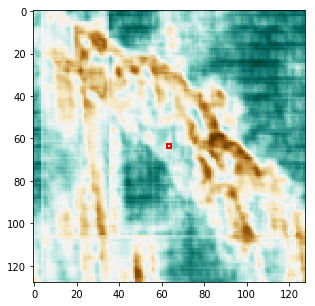

  (Down)


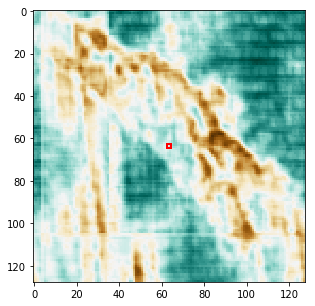

  (Down)


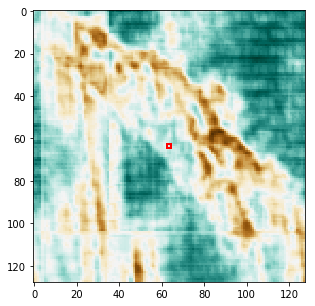

Episode 1: reward: -1.366, steps: 5
-1.3659189343452454


In [27]:
evaluation_info = dqn_model.test(env=env, nb_episodes=1, nb_max_episode_steps=5)
print(np.mean(evaluation_info.history['episode_reward']))